In [2]:
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import torch

#Download dos dados de preço das ações Itau Unibanco com ticker "ITUB4"
df_reduced = yf.download('ITUB4.SA', start="2016-01-01", end="2024-03-31")

[*********************100%%**********************]  1 of 1 completed


In [3]:
#Ordenando valores por data
df_reduced = df_reduced.sort_values(by='Date')

#Calculando a mediana entre abertura e fechamento e atribuindo a coluna median
df_reduced['Median'] = df_reduced[['Open','Close']].median(axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

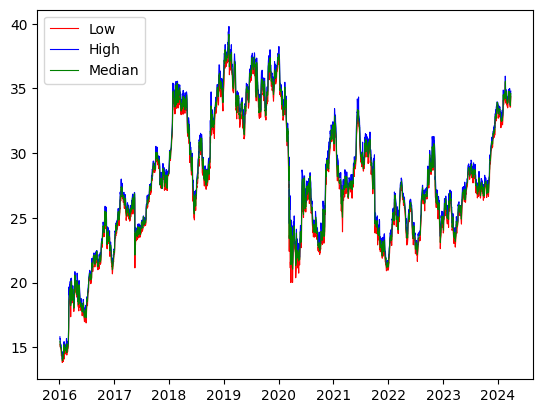

In [43]:
#Gerando gráfico da média de preços da ação
plt.plot(df_reduced['Low'], c='r', linestyle='solid', linewidth = '0.8', label = 'Low')
plt.plot(df_reduced['High'],c='b', linestyle='solid', linewidth = '0.8', label = 'High')
plt.plot(df_reduced['Median'], c='g', linestyle='solid', linewidth = '0.8',label = 'Median')
plt.legend()
plt.show

In [5]:
#Construção dos tensores 
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(df_reduced.iloc[:, 6:7])

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = torch.autograd.Variable(torch.Tensor(np.array(x)))
dataY = torch.autograd.Variable(torch.Tensor(np.array(y)))

trainX = torch.autograd.Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = torch.autograd.Variable(torch.Tensor(np.array(y[0:train_size])))

testX = torch.autograd.Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = torch.autograd.Variable(torch.Tensor(np.array(y[train_size:len(y)])))


In [6]:
#Checagem dos resources da máquina a qual irá rodar o modelo LSTM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
# Definição do Modelo LSTM
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        ula, (h_out, _) = self.lstm(x, (h0, c0))
        h_out = h_out.view((x.size(0), self.hidden_size))
        out = self.fc(h_out)
        return out

In [46]:
# Parâmetros do modelo LSTM
input_size = 1
num_layers = 1
hidden_size = 250
output_size = 1
learning_rate = 0.001    
num_epochs = 52
training_steps_backpropagation = 60
test_steps_backpropagation = 30

#Inicialização do modelo
lstm = LSTMModel(input_size,hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#Train model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    #Obtendo a função loss
    loss = criterion(outputs, trainY)
    loss.backward()

    optimizer.step()
    if epoch % 10 == 0:
        print("Epoca: %d, loss: %1.5f" % (epoch, loss.item()))

Epoca: 0, loss: 0.39483
Epoca: 10, loss: 0.06961
Epoca: 20, loss: 0.03370
Epoca: 30, loss: 0.03211
Epoca: 40, loss: 0.02232
Epoca: 50, loss: 0.01435


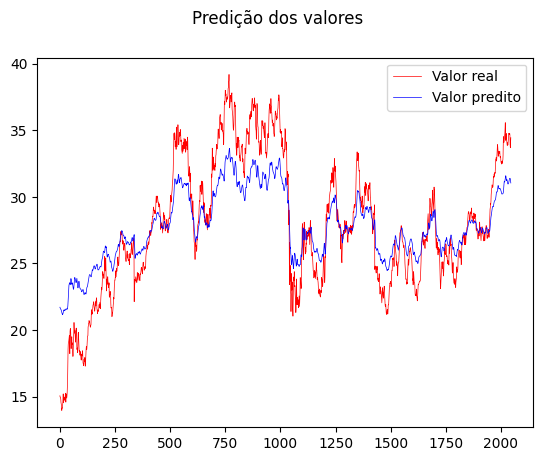

In [47]:
lstm.eval()
train_predict = lstm(dataX)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.plot(dataY_plot,c='r', linestyle='solid', linewidth = '0.5', label="Valor real")
plt.plot(data_predict,c='blue', linestyle='solid', linewidth = '0.5', label="Valor predito")
plt.suptitle('Predição dos valores')
plt.legend()
plt.show()



In [53]:
#Estatísticas da predição
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(dataY_plot,data_predict, squared=False)
print(f"Erro médio: {rmse}")

valor_medio_original = np.mean(dataY_plot)
valor_medio_predicao = np.mean(data_predict)
print(f"Valor médio real: {valor_medio_original}")
print(f"Valor médio predito: {valor_medio_predicao}")

desvpad_originais = np.std(dataY_plot)
desvpad_preditos = np.std(data_predict)
print(f"Desvio padrão real: {desvpad_originais}")
print(f"Desvio padrão predito: {desvpad_preditos}")

Errpad_originais = desvpad_originais/len(dataY_plot)
Errpad_preditos = desvpad_preditos/len(data_predict)
print(f"Erro padrão real: {Errpad_originais}")
print(f"Erro padrão real: {Errpad_preditos}")

Erro médio: 2.500534772872925
Valor médio real: 27.79447364807129
Valor médio predito: 27.7576904296875
Desvio padrão real: 5.021263122558594
Desvio padrão predito: 2.57662034034729
Erro padrão real: 0.002454185299393252
Erro padrão real: 0.001259345229886261


d:\Documentos\Projetos\VS_Code workspace\Forecast_prediction\python_env_cuda_intel\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
